In [7]:

import pandas as pd
from qmt_data import QmtData
import os
import datetime
from xtquant import xtdata

In [8]:
today = datetime.datetime.today().strftime("%Y%m%d")

In [9]:
qmt_data = QmtData()
ticker_df = qmt_data.get_tickers()
stock_list = ticker_df["ticker"].tolist()


In [11]:
def get_trade_date():
    return pd.DataFrame(xtdata.get_trading_dates("SH"), columns=["time"])
def get_div_factors(ticker, end_time):
    df = xtdata.get_divid_factors(
        ticker, 
        start_time="20000101", 
        end_time=end_time
    )
    if df.empty:
        return None
    dates_df = get_trade_date()
    dates_df = dates_df[dates_df["time"] >= df.time.min()]
    df = df.merge(dates_df, on="time", how="right")
    df["time"] = df["time"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    df.insert(1, "ticker_symbol", ticker)
    df.reset_index(drop=True, inplace=True)
    return df.fillna(method="ffill")



In [12]:
factor_list = []
for ticker in stock_list:
    df = get_div_factors(ticker)
    if df is None:
        continue
    factor_list.append(df)

C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_4700\3536294765.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method="ffill")
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_4700\3536294765.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method="ffill")
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_4700\3536294765.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method="ffill")
C:\Users\Wilcoxon\AppData\Local\Temp\ipykernel_4700\3536294765.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method="ffill")
C:\Users\Wilcoxon\AppData\Local\Temp

In [13]:
factor_df = pd.concat(factor_list)

In [18]:
factor_df["year_month"] = factor_df["time"].dt.strftime("%Y%m")
for year_month, df_grouped in factor_df.groupby("year_month"):
    df_copy = df_grouped.copy()
    df_copy.drop(columns=["year_month"], inplace=True)
    df_copy.to_parquet(f"D:\\qmt_datadir\\adjust_factor\\{year_month}.parquet")

: 

: 

In [6]:
import duckdb
conn = duckdb.connect()

df = conn.execute("SELECT * FROM 'D:\\qmt_datadir\\adjust_factor\\200501.parquet'").fetchdf()

In [6]:
from strategy.RSRS import cal_rsrs
import akshare as ak
import pandas as pd
df = ak.stock_us_hist(
    symbol="105.TQQQ", start_date="20100101", end_date="20240903", adjust="hfq"
)

df.rename(
    columns={
        "日期": "trade_time",
        "开盘": "open",
        "收盘": "close",
        "最高": "high",
        "最低": "low",
        "成交量": "volume",
        "成交额": "amount",
    },
    inplace=True,
)
df["trade_time"] = pd.to_datetime(df["trade_time"])
cols = ["open", "high", "low", "close", "volume", "amount"]
df.set_index("trade_time", inplace=True)
zsocre, beta = cal_rsrs(df.low, df.high, 18, 600)
df["zscore"] = zsocre
df["beta"] = beta

[0.74470224 0.73686616 0.73975952 ... 0.91912624 0.92870767 0.9532232 ]
[0.9629612  0.94555397 0.93256586 ... 0.91912624 0.92870767 0.9532232 ]


<Axes: >

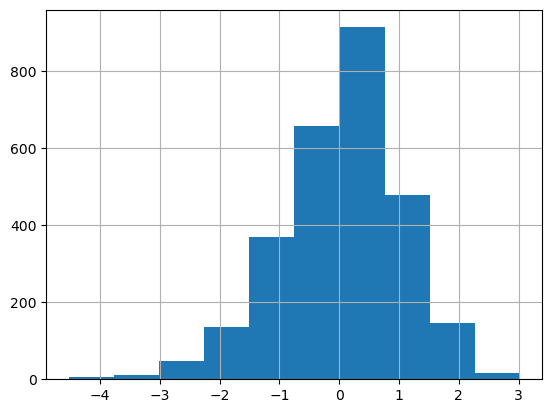

In [7]:
df["zscore"].hist()